# Module 13 - Programming Assignment

## Directions

There are general instructions on Blackboard and in the Syllabus for Programming Assignments. This Notebook also has instructions specific to this assignment. Read all the instructions carefully and make sure you understand them. Please ask questions on the discussion boards or email me at `EN605.645@gmail.com` if you do not understand something.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
You must follow the directions *exactly* or you will get a 0 on the assignment.
</div>

You must submit a zip file of your assignment and associated files (if there are any) to Blackboard. The zip file will be named after you JHED ID: `<jhed_id>.zip`. It will not include any other information. Inside this zip file should be the following directory structure:

```
<jhed_id>
    |
    +--<jhed_id>.ipynb
    +--(any other files)
```

For example, do not name your directory `programming_assignment_01` and do not name your directory `smith122_pr1` or any else. It must be only your JHED ID. You only need to submit the .ipynb file and any auxiliary files. I'll generate the HTML file.

## k Nearest Neighbors and Model Evaluation

You must complete the 4 following tasks:

1. Implement k-Nearest Neighbor *regression* as described in the Module. You can definitely do this in a Python file and import it.
2. Use validation curves as described in Module 9 to determine the best value of k trying values of 1 to 10. Note that you don't need to use odd values of k for regression problems. Create 10 folds and use one fold as your test set...or you can do this 10x and average the results.
3. Use learning curves as described in Module 9 to determine if your model could use more data.
4. Use 10-fold cross-validation to establish confidence bounds on your model's performance. Calculate the mean (average) MSE (which sounds funny, I know) and the standard deviation.

Additionally, because you can't be *wrong* with the k = 1 in the training data, your curves will look a little funky initially.

As before make sure you actually plot curves and that everything is labeled. Each chart from part #2 and #3 has *two* curves. Please review the comments to Module 9 if you're not sure why.

Use the data in concrete_compressive_strength.csv for this assignment obtainable at [UCI ML Repository - Concrete Compressive Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength).

Because the data is always the model, for knn, you simply need a function `knn` that will take the data, a value for k, and a List of instances and return a List of predictions (in this case, we're doing regression...you don't have to write a version of `knn` that would do either).

As before there's a lot of infrastructure involved and the specific names I leave up to you as long as you clearly indicate your answers to 1-4 above.

Additionally, you *must* answer the discussion questions:

## Source Code

In [1]:
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from copy import deepcopy
from random import shuffle

def create_folds(data, k=10):
    '''
    This routine reads the csv file and
    creates k folds of the data set

    Args:
        data - the data
        k - the total folds
    Returns:
        a list of the data partitioned into folds
    '''
    folds = []
    # Calculate the length for each fold
    fold_len = int(len(data)/k)
    # Create k-1 folds
    for i in range(k-1):
        fold = []
        # Create the fold of size fold_len
        while len(fold) < fold_len:
            fold.append(data[0])
            data = np.delete(data, 0, 0)  
        # Add to the folds list
        folds.append(fold)
    # For the final fold add whatever remains in
    # the data set
    folds.append(data)
    # Return the folds
    return folds

def read_data(filename):
    '''
    This routine reads the data from the file

    Args:
        filename - the files name
    Returns
        the data set as a numpy array
    '''
    with open(filename, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        data = []
        for row in csv_reader:
            data.append([float(v) for v in row])
    return np.asarray(data)

def distance(x, y):
    '''
    This routine computes the distance for x
    and all the y points
    
    Args:
        x - a single data point
        y - a numpy array of points
    Returns:
        a numpy array of distances
    '''    
    return np.sum((x-y)**2, axis=1)

def calculate_error(train, test, k):
    '''
    This routine calculates the mean squared error

    Args:
        train - the training set
        test - the testing set
        k - the total neighbors to account for
    Return:
        the MSE
    '''
    squared_errors = []
    for x in test:
        squared_errors.append((x[-1]-knn(k, train, x))**2)
    return sum(squared_errors)/len(squared_errors)
    
def determine_bias_variance(train, test, steps, k):
    '''
    This routine determines the bias variance
    
    Args:
        train - the training set
        test - the testing set
        steps - a list of %s to divide the training set
        k - the k value for NN algorithm
    '''
    train_errors = []
    test_errors = []
    # Iterate over the steps
    for step in steps:
        # Determine the training set length
        train_len = int(step * len(train))
        # Get a list of random indices
        indices = np.random.choice(len(train), train_len, replace=False)
        # Get the rows of interest
        train_pct = train[indices, :]
        # Calculate the errors for both training and testing sets
        train_errors.append(calculate_error(train_pct, train_pct, k))
        test_errors.append(calculate_error(train_pct, test, k))
    return train_errors, test_errors

def cross_validate(data, k, steps=None):
    ''' 
    combine train, classify and evaluate
    to perform 10 fold cross validation, print out the error rate for
    each fold and print the final, average error rate.

    Args:
        data - the data set
    '''
    folds = create_folds(data)
    test_errors = []
    train_errors = []
    # Iterate over the folds
    for fold in range(len(folds)):
        # Copy the entire data set
        train_set = deepcopy(folds)
        # Removing the fold from the training
        # list since this will be the testing set
        test_set = np.asarray(train_set.pop(fold))
        train_set = np.asarray([item for sublist in train_set for item in sublist])
        # If steps is None then just calculate errors
        if steps == None:
            # Calculate the average MSE for the test set
            test_errors.append(calculate_error(train_set, test_set, k))
            # Calculate the average MSE for the train set
            train_errors.append(calculate_error(train_set, train_set, k))
        # Otherwise, calculate the bias variance trade off
        else:
            # Determine bias variance trade off and append to 
            # corresponding list
            train_results, test_results = determine_bias_variance(train_set, test_set, steps, k)
            train_errors.append(train_results)
            test_errors.append(test_results)
    return train_errors, test_errors

**Answer 1.**

In [2]:
def knn(k, data, query):
    '''
    This routine performs the k-nearest neighbor algorithm
    
    Args:
        k - the number of neighbors
        data - the data
        query - the point to query
    Returns:
        the predicted value for the query
    '''    
    # Assuming that the query has it's real value.
    # Removing it in order to predict
    x = query[:-1]
    # Calculate the distances of x to the data points
    # ignoring the actual value column
    distances = distance(x, data[:,:-1])
    # Determine the k closest values to x
    min_indices = np.argpartition(distances, k)[:k]
    # Extract the rows of interest and their actual
    # values. Return the average
    return np.sum(data[min_indices,-1])/k

**Additional Setup**

In [11]:
# Read the data
data = read_data('concrete_compressive_strength.csv')
# Shuffle the data a few times in order
# to randomize the set
shuffle(data)
# Lists to keep track of the folds
avg_mse_test_folds = []
avg_mse_train_folds = []
test_folds_mse = []
train_folds_mse = []

**Answer 2.**

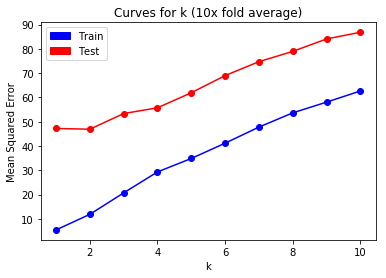

Best k value: 2


In [12]:
# Create a list of k values
k = [x for x in range(1, 11)]
# Iterate over the k values
for val in k:
    train_mse, test_mse = cross_validate(data, val)
    avg_mse_test_folds.append(sum(test_mse)/len(test_mse))
    avg_mse_train_folds.append(sum(train_mse)/len(train_mse))
    test_folds_mse.append(test_mse)
    train_folds_mse.append(train_mse)
# Plot the data
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
test_patch = mpatches.Patch(color='red', label='Test')
train_patch = mpatches.Patch(color='blue', label='Train')
plt.legend(handles=[train_patch, test_patch])
plt.plot(k, avg_mse_train_folds, "bo-", k, avg_mse_test_folds, "ro-")
plt.title("Curves for k (10x fold average)")
plt.show()
k_val = avg_mse_test_folds.index(min(avg_mse_test_folds)) + 1
print("Best k value:", k_val)

**Answer 3.**

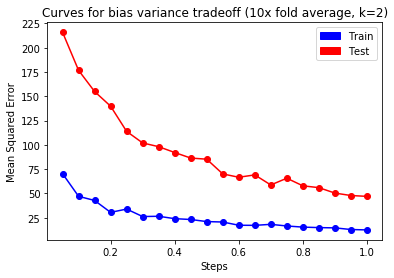

In [13]:
# Create a list of values 0.05 - 1.0
steps = list(np.arange(0.05, 1.05, 0.05)) 
# Perform cross validation
train_mse, test_mse = cross_validate(data, k_val, steps)
# Calculate the average over the folds for both sets
train_mse = np.sum(train_mse, axis=0)/len(train_mse)
test_mse = np.sum(test_mse, axis=0)/len(test_mse)
#Plot the data
plt.xlabel('Steps')
plt.ylabel('Mean Squared Error')
test_patch = mpatches.Patch(color='red', label='Test')
train_patch = mpatches.Patch(color='blue', label='Train')
plt.legend(handles=[train_patch, test_patch])
plt.title("Curves for bias variance tradeoff (10x fold average, k=" + str(k_val) + ")")
plt.plot(steps, train_mse, "bo-", steps, test_mse, "ro-")
plt.show()

**Answer 4.**

In [14]:
# Calculate the average MSE over all the k's MSE
avg_test_mse = sum(avg_mse_test_folds)/len(avg_mse_test_folds)
avg_train_mse = sum(avg_mse_train_folds)/len(avg_mse_train_folds)
# Calculate the std deviation
test_std = np.sqrt(np.sum((np.asarray(avg_mse_test_folds)-avg_test_mse)**2)/len(avg_mse_test_folds))
train_std = np.sqrt(np.sum((np.asarray(avg_mse_train_folds)-avg_train_mse)**2)/len(avg_mse_train_folds))
print("Best k value:", k_val)
print()
print("Metrics for the testing set:")
print("\tAverage MSE:", avg_test_mse)
print("\tStd. Deviation:", test_std)
print()
print("Metrics for the training set:")
print("\tAverage MSE:", avg_train_mse)
print("\tStd. Deviation:", train_std)

Best k value: 2

Metrics for the testing set:
	Average MSE: 65.8682483148405
	Std. Deviation: 14.179602342272874

Metrics for the training set:
	Average MSE: 36.56080512953782
	Std. Deviation: 18.61185994408321


## Discussion

**1. Compare and contrast linear regression and kNN for a regression problem. What are the various pros/cons for each algorithm?**

Linear regression aims to find a relationship between a target and predicted values.
    Pros:
        Only weights are saved, low space complexity
        Works well if data has linear interpretation
    Cons:
        Not suited for non-linear data
        Sensitive to outliers
        
kNN predicts a value based on the information of  k neighbors of the query point.
    Pros:
        Model doesn't need to be trained
        Assumptions on data are not made
    Cons:
        Very slow on large data sets
        Curse of dimensionality
        Sensitive to outliers
        
Ultimatly the data set determines which algorithm is to be used.

**2\. Will more data always make a model better? How do learning curves fit into this?**

More data does not necessarily make a model better. In order to gain insight on how well the model performs is to determine it's bias and variance. When a model is underfitting this indicates that the model has a low variance and high bias, which means that the model can't find the trend of the data. When the model is overfitting this indicates high variance and low bias, which means the noise of the data is being captured. 

To visualize the bias variance tradeoff metrics of the model is to use plot learning curves of the training and testing sets. If the trailing ends of the curves meet (100% case) then this is the high bias case where more data will not help but adding more features may help. When there is a gap at the trailing ends of the curves then this is the high variance case where more date and/or reducing features may help.

**3\. Why can't you use test or evaluate your model on the same data you trained it with? How does cross-validation fit into this? Do learning curves violate this?**

If the the model is tested with the same data it was trained with, then the model will perform really well because the same data is used and the model really isn't exercising what it has learned. In order to prevent this cross-validation is used, this technique partitions the data set into training and testing sets. Cross-validation creates partitions/folds of the entire data set, if 5 folds are created then fold 1 is used as the testing set and folds 2-5 are used to train a model. To get a better idea on how the model performs each fold can become a testing set while the others become the training set and at each iteration metrics are recorded to get insight of the model. Learning curves used in conjunction with cross-validation does not violate the use of using the same data for both training and testing. Cross-validation provides variety of metrics that can be used to create learning curves to understand how the model is performing.